<a href="https://colab.research.google.com/github/robitussin/CCRNFLRL_EXERCISES/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Exercise 7

In this exercise, you will train a **Deep Q-Network (DQN)** to play the
[CartPole-v1 environment](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) from Gymnasium.

`CartPole-v1` is a classic reinforcement learning task where a pole is attached to a cart that moves along a horizontal track . The **goal**: is to keep the pole upright as long as possible  

**State Space**:  
  1. Cart position  
  2. Cart velocity  
  3. Pole angle  
  4. Pole angular velocity  

**Action Space**:  
  1. Push cart to the **left**  
  2. Push cart to the **right**  

**Reward**: +1 for every timestep the pole remains upright  

**Episode ends** when:  
  - The pole angle exceeds ±12°  
  - The cart moves beyond the edges of the track  
  - Maximum of 500 timesteps is reached


## Step 1: Install dependencies



In [1]:
# !pip install gymnasium torch numpy matplotlib imageio[ffmpeg] --quiet

## Step 2: Imports


In [2]:
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video


In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda

NVIDIA GeForce GTX 1650


## Step 3: Define the Deep Q-Network



In [4]:
# put your answer here
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

## Step 4: Replay Buffer

We store past experiences `(state, action, reward, next_state, done)`  
in a buffer and sample random minibatches for training.  
This **breaks correlation** between consecutive samples and stabilizes learning.


In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones),
        )

    def __len__(self):
        return len(self.buffer)

## Step 5: Training Function




In [ ]:
# Set hyperparametes
episodes=1000
gamma=0.99
lr=0.0001
batch_size=64
epsilon_decay=0.998
min_epsilon=0.01
target_update_freq=500

In [ ]:
def train_dqn(env_name, 
              episodes,
              gamma,
              lr,
              batch_size,
              epsilon_decay,
              min_epsilon,
              target_update_freq):   # new param

    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    q_net = DQN(state_size, action_size)
    target_net = DQN(state_size, action_size)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=lr)

    memory = ReplayBuffer(5000)
    epsilon = 1.0
    rewards_history = []
    step_count = 0

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            # ε-greedy policy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state)
                with torch.no_grad():
                    action = torch.argmax(q_net(state_tensor)).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1   # increment step counter

            # Train network
            if len(memory) >= batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)
                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                next_q = target_net(next_states).max(1)[0].detach()
                targets = rewards + gamma * next_q * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network based on steps
            if step_count % target_update_freq == 0:
                target_net.load_state_dict(q_net.state_dict())

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_history.append(total_reward)

        if ep % 50 == 0:
            print(f"Episode {ep}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    env.close()
    return q_net, rewards_history

In [8]:
# def train_dqn(env_name, 
#               episodes,
#               gamma,
#               lr,
#               batch_size,
#               epsilon_decay,
#               min_epsilon):

#     env = gym.make(env_name)
#     state_size = env.observation_space.shape[0]
#     action_size = env.action_space.n
    

#     q_net = DQN(state_size, action_size)
#     target_net = DQN(state_size, action_size)
#     target_net.load_state_dict(q_net.state_dict())
#     optimizer = optim.Adam(q_net.parameters(), lr=lr)

#     memory = ReplayBuffer(5000)
#     epsilon = 1.0
#     rewards_history = []

#     for ep in range(episodes):
#         state, _ = env.reset()
#         done = False
#         total_reward = 0

#         while not done:
#             # ε-greedy policy
#             if random.random() < epsilon:
#                 action = env.action_space.sample()
#             else:
#                 state_tensor = torch.FloatTensor(state)
#                 with torch.no_grad():
#                     action = torch.argmax(q_net(state_tensor)).item()

#             next_state, reward, terminated, truncated, _ = env.step(action)
#             done = terminated or truncated

#             memory.push(state, action, reward, next_state, done)
#             state = next_state
#             total_reward += reward

#             # Train network
#             if len(memory) >= batch_size:
#                 states, actions, rewards, next_states, dones = memory.sample(batch_size)
#                 q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze()
#                 next_q = target_net(next_states).max(1)[0].detach()
#                 targets = rewards + gamma * next_q * (1 - dones)

#                 loss = nn.MSELoss()(q_values, targets)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#         epsilon = max(min_epsilon, epsilon * epsilon_decay)
#         rewards_history.append(total_reward)

#         # Update target network periodically
#         if ep % 50 == 0:
#             target_net.load_state_dict(q_net.state_dict())
#             print(f"Episode {ep}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")

#     env.close()
#     return q_net, rewards_history


## Step 6: Train the Agent

In [9]:
q_net, rewards = train_dqn(env_name="CartPole-v1",
                           episodes=episodes,
                           gamma=gamma,
                           lr=lr,
                           batch_size=batch_size,
                           epsilon_decay=epsilon_decay,
                           min_epsilon=min_epsilon,
                           target_update_freq=target_update_freq)

Episode 0, Reward: 10.0, Epsilon: 1.00


C:\Users\Neil\AppData\Local\Temp\ipykernel_14000\2861239376.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  torch.FloatTensor(states),


Episode 50, Reward: 21.0, Epsilon: 0.90
Episode 100, Reward: 54.0, Epsilon: 0.82
Episode 150, Reward: 26.0, Epsilon: 0.74
Episode 200, Reward: 48.0, Epsilon: 0.67
Episode 250, Reward: 23.0, Epsilon: 0.61
Episode 300, Reward: 42.0, Epsilon: 0.55
Episode 350, Reward: 200.0, Epsilon: 0.50
Episode 400, Reward: 172.0, Epsilon: 0.45
Episode 450, Reward: 263.0, Epsilon: 0.41
Episode 500, Reward: 51.0, Epsilon: 0.37
Episode 550, Reward: 290.0, Epsilon: 0.33
Episode 600, Reward: 394.0, Epsilon: 0.30
Episode 650, Reward: 264.0, Epsilon: 0.27
Episode 700, Reward: 500.0, Epsilon: 0.25
Episode 750, Reward: 500.0, Epsilon: 0.22
Episode 800, Reward: 500.0, Epsilon: 0.20
Episode 850, Reward: 249.0, Epsilon: 0.18
Episode 900, Reward: 500.0, Epsilon: 0.16
Episode 950, Reward: 500.0, Epsilon: 0.15


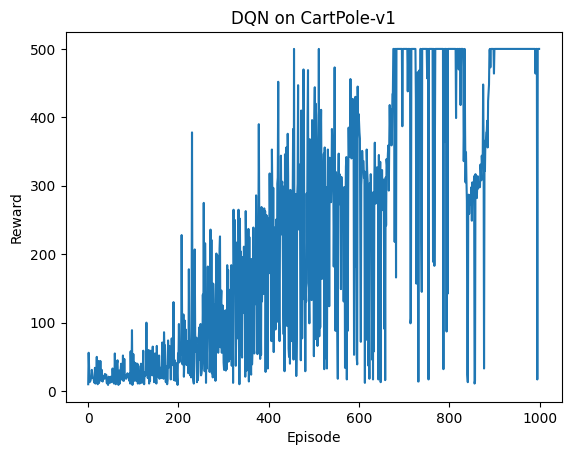

In [10]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN on CartPole-v1")
plt.show()

## Step 7: Record Multiple Episodes as Video


In [17]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
video_path = "cartpole_dqn.mp4"
writer = imageio.get_writer(video_path, fps=30)

for ep in range(10):
    state, _ = env.reset()
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state)
        with torch.no_grad():
            action = torch.argmax(q_net(state_tensor)).item()
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        frame = env.render()
        writer.append_data(frame)

writer.close()
env.close()
print(f"Video saved to {video_path}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to cartpole_dqn.mp4


## 8. Watch the video

In [18]:
Video("cartpole_dqn.mp4", embed=True)

## 9. Evaluate Agent

In [19]:
def evaluate_agent(env, q_net, episodes=20):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            state_tensor = torch.FloatTensor(state)
            with torch.no_grad():
                action = torch.argmax(q_net(state_tensor)).item()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
        total_rewards.append(ep_reward)
    return np.mean(total_rewards)

eval_env = gym.make("CartPole-v1")
avg_reward = evaluate_agent(eval_env, q_net, episodes=20)
print(f"Average reward over 20 eval episodes: {avg_reward:.2f}")
eval_env.close()


Average reward over 20 eval episodes: 500.00
